## Analysis of EM and confocal data
(Figure 3 and S3)


In [1]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd

# for moG
from sklearn import mixture
import sklearn

# import helper functions
from helpers import normalize, get_bootstrapped_confs


# Confocal data

In [2]:
"""
read in the confocal data
(excel file)
"""
filepath = '../data/'
filename = 'HC connectivity for clustering - confocal.xlsx'
data = pd.read_excel (filepath+filename, header =1 )[::-1]

# delete empty columns
data = data.drop(columns=['Unnamed: 1','Unnamed: 2','Unnamed: 9' ])

# R, G, O+B are counts.
# R.1 etc. relative counts.

confocal_df = data

# add a UNIQUE ID
confocal_df['ID'] = np.arange(24,-1,-1)

# show head of data
confocal_df.head()

,HC ID,Area size (um2),Tip density,R,G,O+B,Total,R.1,G.1,O+B.1,ID
24,Leye_Eye1_region1,146,0.130137,5,5,9,19,0.263158,0.263158,0.473684,24
23,Reye_Eye1_region2-3,122,0.147541,10,2,6,18,0.555556,0.111111,0.333333,23
22,Reye_Eye1_region2-2,160,0.118750,5,8,6,19,0.263158,0.421053,0.315789,22
21,Reye_Eye1_region2-1,144,0.145833,11,4,6,21,0.523810,0.190476,0.285714,21
20,Reye_Eye1_region1-1,158,0.145570,8,7,8,23,0.347826,0.304348,0.347826,20


In [3]:
"""
Add ad hoc clustering to the data frame
"""

# manually assigned types

types_TY = np.array([['Reye2_Eye5_region1',
    'Reye2_Eye4_region1',
    'Leye2_Eye9_region1',
    'Reye_Eye1_region2_1',
    'Reye_Eye1_region2_1goodexample'],
    ['Reye2_Eye1_region1',
    'Leye2_Eye9_region2_2_map2',
    'Leye2_Eye9_region2_2_map3',
    'Leye_Eye2_region1',
    'Leye_Eye4_region_whole2',
    'Leye2_Eye8_region1',
    'Reye_Eye1_region1-1',
    'Reye_Eye1_region1-2',
    'Reye_Eye3_region1',
    'Leye_Eye1_region2',],
    ['Reye2_Eye1_region2_2',
    'Leye2_Eye9_region1_2',
    'Leye2_Eye9_region1_3',
    'Leye2_Eye9_region1_4',
    'Leye2_Eye9_region2_2',
    'Reye_Eye1_region1-1',
    'Reye_Eye1_region2-1',
    'Reye_Eye1_region2-2',
    'Reye_Eye1_region2-3',
    'Leye_Eye1_region1']])




confocal_df['cluster_TY'] = np.nan
for label in confocal_df['HC ID']:
    if label in types_TY[0]:
        confocal_df.loc[confocal_df['HC ID']==label,'cluster_TY'] =1
    elif label in types_TY[1]:
        confocal_df.loc[confocal_df['HC ID']==label,'cluster_TY'] =2
    elif label in types_TY[2]:
        confocal_df.loc[confocal_df['HC ID']==label,'cluster_TY'] =3
        
confocal_df=confocal_df.astype({'cluster_TY': 'int32'}) 

confocal_df

<ipython-input-3-fa0768d7d1f6>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  types_TY = np.array([['Reye2_Eye5_region1',


,HC ID,Area size (um2),Tip density,R,G,O+B,Total,R.1,G.1,O+B.1,ID,cluster_TY
24,Leye_Eye1_region1,146,0.130137,5,5,9,19,0.263158,0.263158,0.473684,24,3
23,Reye_Eye1_region2-3,122,0.147541,10,2,6,18,0.555556,0.111111,0.333333,23,3
22,Reye_Eye1_region2-2,160,0.118750,5,8,6,19,0.263158,0.421053,0.315789,22,3
21,Reye_Eye1_region2-1,144,0.145833,11,4,6,21,0.523810,0.190476,0.285714,21,3
20,Reye_Eye1_region1-1,158,0.145570,8,7,8,23,0.347826,0.304348,0.347826,20,2
19,Leye2_Eye9_region2_2,133,0.150376,12,5,3,20,0.600000,0.250000,0.150000,19,3
18,Leye2_Eye9_region1_4,136,0.147059,10,4,6,20,0.500000,0.200000,0.300000,18,3
17,Leye2_Eye9_region1_3,82,0.158537,10,1,2,13,0.769231,0.076923,0.153846,17,3
16,Leye2_Eye9_region1_2,89,0.168539,10,2,3,15,0.666667,0.133333,0.200000,16,3
15,Reye2_Eye1_region2_2,243,0.123457,16,3,11,30,0.533333,0.100000,0.366667,15,3


#### check loaded data

Text(0.5, 0, 'R+G')

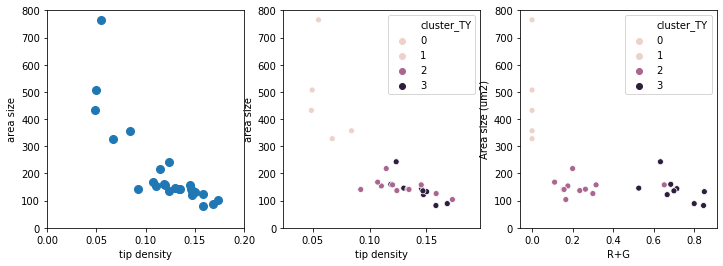

In [20]:
plt.figure(1,figsize=(12,4))

plt.subplot(131)
plt.plot(confocal_df['Tip density'], 
         confocal_df['Area size (um2)'], 
        'o',
        markersize=8,
        )


plt.xlim(0,0.2)
plt.ylim(0,800)
plt.xlabel('tip density')
plt.ylabel('area size')


plt.subplot(132)
sns.scatterplot(x='Tip density', 
         y='Area size (um2)', 
        data=confocal_df,
        hue='cluster_TY'
                )
plt.ylim(0,800)
plt.xlabel('tip density')
plt.ylabel('area size')


plt.subplot(133)
sns.scatterplot(x=confocal_df['R.1']+confocal_df['G.1'], 
         y='Area size (um2)', 
        data=confocal_df,
        hue='cluster_TY'
                )
plt.ylim(0,800)
plt.xlabel('R+G')


### Perform MoG clustering on all features

In [5]:
# normalize features
features = ['Area size (um2)', 	'Tip density' ,'R.1' ,'G.1','O+B.1']
data_raw = np.zeros((25, len(features)))

for i,feature in enumerate(features):
    data_raw[:,i] = confocal_df[feature].values

# zscor data 
data_norm = normalize(data_raw.T,mode='z_score').T

In [8]:
# choose data
data = data_norm

random_state = 123


n_clusters=3

# fit a Gaussian Mixture Model with n components
clf = mixture.GaussianMixture(n_components=n_clusters, 
                              covariance_type='full', 
                             random_state=random_state) 
clf.fit(data)

y_pred = clf.predict(data)


# get partition

partition_moG = [[] for _ in range(n_clusters)]
for i in range(n_clusters):
    partition_moG[i] = np.arange(len(y_pred))[y_pred==i]

    
number_cluster_elements = [partition_moG[0].shape[0] , 
                           partition_moG[1].shape[0], 
                           partition_moG[2].shape[0]]

print(number_cluster_elements)
print(partition_moG)

[10, 5, 10]
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([20, 21, 22, 23, 24]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])]


In [9]:
"""
run multiple times and compare BIC
"""

data = data_norm

n_components = 3

verbose=False 

bic = []
aic = []
y_pred_all = []
gmm_all = []

random_states = np.arange(100)

cv_types = ['full'] #['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for random_state in random_states:

        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                     random_state=random_state)
        gmm.fit(data)
        bic.append(gmm.bic(data))
        aic.append(gmm.aic(data))
        
        y_pred = gmm.predict(data)
        y_pred_all.append(y_pred)
        
        gmm_all.append(gmm)


        
        
        if verbose:
            print('finished random_state', random_state)

bic = np.array(bic)
aic = np.array(aic)
y_pred_all = np.array(y_pred_all)

# get partition
partition_moG_all = [[[] for _ in range(n_clusters)] for i in range(len(random_states))]
for r in range(len(random_states)):
    for i in range(n_clusters):
        partition_moG_all[r][i] = np.arange(len(y_pred_all[0]))[y_pred_all[r]==i]

# get number of cluster elements
n_cluster_elements_all = []
for i in range(0,len(random_states)):
    n_cluster_elements_all.append([ partition_moG_all[i][0].shape[0] , 
                               partition_moG_all[i][1].shape[0], 
                               partition_moG_all[i][2].shape[0]])
    

# plot BIC
if verbose:
    plt.plot(bic, 'o')

    
"""
compare clusters with same BIC 
"""

min_bic = np.min(bic)

best_indeces = random_states[np.isclose(bic, min_bic)]

# get partition best
partition_moG_best = [[[] for _ in range(n_clusters)] for i in range(len(best_indeces))]
for r in range(len(best_indeces)):
    for i in range(n_clusters):
        partition_moG_best[r][i] = np.arange(len(y_pred_all[0]))[y_pred_all[r]==i]

# get number of cluster elements
n_cluster_elements = []
for i in range(0, len(best_indeces)):
    n_cluster_elements.append([ partition_moG_best[i][0].shape[0] , 
                               partition_moG_best[i][1].shape[0], 
                               partition_moG_best[i][2].shape[0]])


# sorting in ascending number of elements order
partition_sorted = []
for  i in range(len(best_indeces)):
    #partition_sorted.append([x for _,x in sorted(zip(n_cluster_elements[i],partition_moG_best[i]))])
    
    inds = np.array(n_cluster_elements[i]).argsort()
    partition_sorted.append([partition_moG_best[i][inds[0]],
                partition_moG_best[i][inds[1]],
                partition_moG_best[i][inds[2]]])
    
    n_cluster_elements[i].sort()
    
if verbose:
    print("number of cluster elements:", n_cluster_elements)
    
"""
check for one specific partition
"""

count=0

for i in range(len(best_indeces)):

    count_list =0 
    for item in partition_sorted[i][1] :
        if item in  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            count_list+=1
        if count_list==10:
            count+=1
            
    count_list =0 
    for item in partition_sorted[i][2] :
        if item in  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            count_list+=1
        if count_list==10:
            count+=1
            
print('number of same partitions:', count)
print('out of ',len(partition_moG_best), ' best partitions')

number of same partitions: 27
out of  49  best partitions


In [10]:
"""
insert in df
"""
final_partition = np.array([np.array([20, 21, 22, 23, 24]),
 np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])])

cluster_names =  [2]*10 + [1]*10 +[0]*5 
confocal_df['cluster_CS'] = cluster_names


confocal_df[confocal_df['cluster_CS']==0]

<ipython-input-10-336ac36ccadf>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  final_partition = np.array([np.array([20, 21, 22, 23, 24]),


,HC ID,Area size (um2),Tip density,R,G,O+B,Total,R.1,G.1,O+B.1,ID,cluster_TY,cluster_CS
4,Reye_Eye1_region2_1goodexample,328,0.067073,0,0,22,22,0.0,0.0,1.0,4,1,0
3,Reye_Eye1_region2_1,507,0.049310,0,0,25,25,0.0,0.0,1.0,3,1,0
2,Leye2_Eye9_region1,765,0.054902,0,0,42,42,0.0,0.0,1.0,2,1,0
1,Reye2_Eye4_region1,432,0.048611,0,0,21,21,0.0,0.0,1.0,1,1,0
0,Reye2_Eye5_region1,357,0.084034,0,0,30,30,0.0,0.0,1.0,0,1,0


## bootstrap confidence intervals 

In [11]:
"""
compute confs and construct df
"""

save=False

# configure bootstrap
n_iterations = 1000
p_conf = 95
data_per_iteration = 1

HC_types = ['H3', 'H2', 'H1']

# run over different data
confs = np.zeros((3,3,3)) # cluster, conetype, percentiles
for cluster_nr in range(3):
    for i,cone_type in enumerate(['R.1','G.1','O+B.1']): 	
        values = confocal_df[confocal_df['cluster_CS']==cluster_nr][cone_type].values
        confs[cluster_nr][i] = get_bootstrapped_confs(values, p_conf=p_conf, data_per_iteration=data_per_iteration)

df = pd.DataFrame(columns=['HC_cluster', 'cone_type', 'p_2.5', 'data_mean', 'p_97.5'])
for cluster_nr in range(3):
    for cone_nr,cone_type in enumerate(['R', 'G', 'O+B']):
        df.loc[-1] = [HC_types[cluster_nr], cone_type, 
                      confs[cluster_nr][cone_nr][0],
                      confs[cluster_nr][cone_nr][1],
                      confs[cluster_nr][cone_nr][2]]  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index
        

"""
save to excel file
"""
if save:
    df.to_excel('confocal_confidence_intervals.xlsx')
    
df

,HC_cluster,cone_type,p_2.5,data_mean,p_97.5
0,H1,O+B,0.231696,0.292686,0.353023
1,H1,G,0.146650,0.205040,0.269982
2,H1,R,0.405931,0.502274,0.601438
3,H2,O+B,0.752371,0.791977,0.829486
4,H2,G,0.159987,0.202760,0.245672
5,H2,R,0.000000,0.005263,0.015789
6,H3,O+B,1.000000,1.000000,1.000000
7,H3,G,0.000000,0.000000,0.000000
8,H3,R,0.000000,0.000000,0.000000


# EM data

In [2]:
"""
read in the EM data
(excel file)
"""
filepath = '../data/'
filename = 'HC connectivity for clustering - EM .xlsx'
data = pd.read_excel (filepath+filename, header =1 )

# delete empty columns
data = data.drop(columns=['Unnamed: 6'])

# R, G, O+B are counts. 
# R.1 etc. relative 

em_df = data


"""
add ad hoc clustering
"""
em_clusters_TY = [['HC2',
'HC5',
'HC7',
'HC8',
'HC12',
'HC13',
'HC14',
'HC15',],
['HC1',
'HC3',
'HC4',
'HC6',
'HC9',
'HC11'],
['HC16',
'HC10']]



em_df['cluster_TY'] = np.nan
for label in em_df['HC ID']:
    if label in em_clusters_TY[0]:
        em_df.loc[em_df['HC ID']==label,'cluster_TY'] =0
    elif label in em_clusters_TY[1]:
        em_df.loc[em_df['HC ID']==label,'cluster_TY'] =1
    elif label in em_clusters_TY[2]:
        em_df.loc[em_df['HC ID']==label,'cluster_TY'] =2
        
em_df=em_df.astype({'cluster_TY': 'int32'}) 

em_df.head()


em_df.head()

,HC ID,Area size(um2),RorG,B,U,Total,RorG.1,B.1,U.1,cluster_TY
0,HC1,207.338177,6,2,10,18,0.333333,0.111111,0.555556,1
1,HC2,162.631384,7,2,1,10,0.700000,0.200000,0.100000,0
2,HC3,156.087376,5,1,10,16,0.312500,0.062500,0.625000,1
3,HC4,126.433652,3,1,8,12,0.250000,0.083333,0.666667,1
4,HC5,161.822766,9,3,3,15,0.600000,0.200000,0.200000,0


### check loaded data


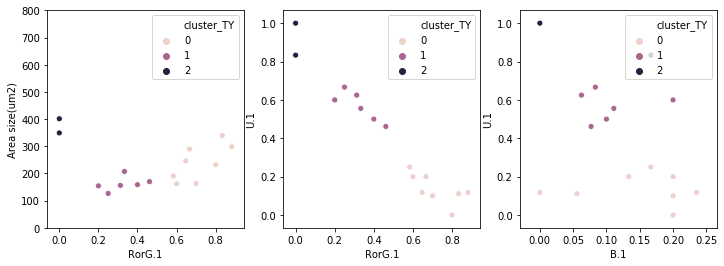

In [3]:

plt.figure(1,figsize=(12,4))
plt.subplot(131)
sns.scatterplot(x='RorG.1', 
         y='Area size(um2)', 
        data=em_df,
        hue='cluster_TY'
                )
plt.ylim(0,800)


plt.subplot(132)
sns.scatterplot(x='RorG.1',
            y='U.1', 
        data=em_df,
        hue='cluster_TY'
                )

plt.subplot(133)
sns.scatterplot(x='B.1',
            y='U.1', 
        data=em_df,
        hue='cluster_TY'
                )



### mog clustering

In [4]:
# normalize features
features = ['Area size(um2)', 	  'RorG.1' ,'B.1','U.1']
data_raw = np.zeros((16, len(features)))

for i,feature in enumerate(features):
    data_raw[:,i] = em_df[feature].values

# zscor data 
data_norm = normalize(data_raw.T, mode='z_score').T


In [5]:
# choose data
data = data_norm

random_state = 5


n_clusters=3
# fit a Gaussian Mixture Model with n components
clf = mixture.GaussianMixture(n_components=n_clusters, 
                              covariance_type='full', 
                             random_state=random_state) 
clf.fit(data)

y_pred = clf.predict(data)



# get partition

partition_moG = [[] for _ in range(n_clusters)]
for i in range(n_clusters):
    partition_moG[i] = np.arange(len(y_pred))[y_pred==i]

    
number_cluster_elements = [partition_moG[0].shape[0] , 
                           partition_moG[1].shape[0], 
                           partition_moG[2].shape[0]]

print(number_cluster_elements)

[11, 2, 3]


In [6]:
"""
run multiple times and compare BIC
"""

data = data_norm

n_components = 3

verbose=False

bic = []
aic = []
y_pred_all = []
gmm_all = []

random_states = np.arange(1000)

cv_types = ['full'] #['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for random_state in random_states:

        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                     random_state=random_state)
        gmm.fit(data)
        bic.append(gmm.bic(data))
        aic.append(gmm.aic(data))
        
        y_pred = gmm.predict(data)
        y_pred_all.append(y_pred)
        
        gmm_all.append(gmm)


        
        
        if verbose:
            print('finished random_state', random_state)

bic = np.array(bic)
aic = np.array(aic)
y_pred_all = np.array(y_pred_all)

# get partition
partition_moG_all = [[[] for _ in range(n_clusters)] for i in range(len(random_states))]
for r in range(len(random_states)):
    for i in range(n_clusters):
        partition_moG_all[r][i] = np.arange(len(y_pred_all[0]))[y_pred_all[r]==i]

# get number of cluster elements
n_cluster_elements_all = []
for i in range(0,len(random_states)):
    n_cluster_elements_all.append([ partition_moG_all[i][0].shape[0] , 
                               partition_moG_all[i][1].shape[0], 
                               partition_moG_all[i][2].shape[0]])
    
    
"""
compare clusters with same BIC 
"""

min_bic = np.min(bic)

best_indeces = random_states[np.isclose(bic, min_bic)]
#np.arange(0,len(random_states))
#random_states[np.isclose(bic, min_bic)]


# get partition best
partition_moG_best = [[[] for _ in range(n_clusters)] for i in range(len(best_indeces))]
for r in range(len(best_indeces)):
    for i in range(n_clusters):
        partition_moG_best[r][i] = np.arange(len(y_pred_all[0]))[y_pred_all[r]==i]

# get number of cluster elements
n_cluster_elements = []
for i in range(0, len(best_indeces)):
    n_cluster_elements.append([ partition_moG_best[i][0].shape[0] , 
                               partition_moG_best[i][1].shape[0], 
                               partition_moG_best[i][2].shape[0]])


# sorting in ascending number of elements order
partition_sorted = []
for  i in range(len(best_indeces)):
    #partition_sorted.append([x for _,x in sorted(zip(n_cluster_elements[i],partition_moG_best[i]))])
    
    inds = np.array(n_cluster_elements[i]).argsort()
    partition_sorted.append([partition_moG_best[i][inds[0]],
                partition_moG_best[i][inds[1]],
                partition_moG_best[i][inds[2]]])
    
    n_cluster_elements[i].sort()
    
    
"""
check for one specific partition
"""

count=0

for i in range(len(best_indeces)):

    count_list_0 =0 
    count_list_1 =0 

    for item in partition_sorted[i][0] :
        if item in  [9,15] :
            count_list_0+=1
            
    for item in partition_sorted[i][1] :
        if item in  [0,  2,  3,  5,  8, 10]:
            count_list_1+=1
            
    if count_list_0==2 and count_list_1==6:
        count+=1
            
    
            
print('number of same partitions:', count)
print('out of ',len(partition_moG_best), ' best partitions')

if verbose:
    print("partitions")
    for i in range(len(best_indeces)):
        print(i, partition_sorted[i][0],'   ', partition_sorted[i][1],'            ',partition_sorted[i][2])

number of same partitions: 21
out of  42  best partitions


In [16]:
"""
add this clustering to dataframe
"""
c1 = [ 'HC'+str(x) for x in np.array([ 9, 15])+1]
c2 = [ 'HC'+str(x) for x in np.array([0,  2,  3,  5,  8, 10])+1] 
c3 = [ 'HC'+str(x) for x in np.array([ 1,  4, 6, 7, 11, 12, 13, 14])+1] 


em_clusters_CS = [c3,c2,c1]



em_df['cluster_CS'] = np.nan
for label in em_df['HC ID']:
    if label in em_clusters_CS[0]:
        em_df.loc[em_df['HC ID']==label,'cluster_CS'] =0
    elif label in em_clusters_CS[1]:
        em_df.loc[em_df['HC ID']==label,'cluster_CS'] =1
    elif label in em_clusters_CS[2]:
        em_df.loc[em_df['HC ID']==label,'cluster_CS'] =2
        
em_df=em_df.astype({'cluster_CS': 'int32'}) 

em_df.head()

,HC ID,Area size(um2),RorG,B,U,Total,RorG.1,B.1,U.1,cluster_TY,cluster_CS
0,HC1,207.338177,6,2,10,18,0.333333,0.111111,0.555556,1,1
1,HC2,162.631384,7,2,1,10,0.700000,0.200000,0.100000,0,0
2,HC3,156.087376,5,1,10,16,0.312500,0.062500,0.625000,1,1
3,HC4,126.433652,3,1,8,12,0.250000,0.083333,0.666667,1,1
4,HC5,161.822766,9,3,3,15,0.600000,0.200000,0.200000,0,0


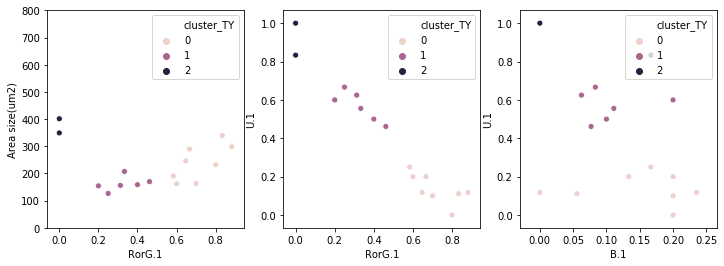

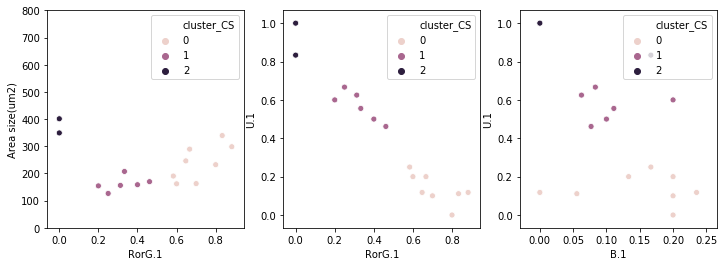

In [12]:
"""
compare ad hoc and MoG clustering
"""
plt.figure(1,figsize=(12,4))
plt.subplot(131)
sns.scatterplot(x='RorG.1', 
         y='Area size(um2)', 
        data=em_df,
        hue='cluster_TY'
                )
plt.ylim(0,800)


plt.subplot(132)
sns.scatterplot(x='RorG.1',
            y='U.1', 
        data=em_df,
        hue='cluster_TY'
                )

plt.subplot(133)
sns.scatterplot(x='B.1',
            y='U.1', 
        data=em_df,
        hue='cluster_TY'
                )



plt.figure(2,figsize=(12,4))
plt.subplot(131)
sns.scatterplot(x='RorG.1', 
         y='Area size(um2)', 
        data=em_df,
        hue='cluster_CS'
                )
plt.ylim(0,800)


plt.subplot(132)
sns.scatterplot(x='RorG.1',
            y='U.1', 
        data=em_df,
        hue='cluster_CS'
                )

plt.subplot(133)
sns.scatterplot(x='B.1',
            y='U.1', 
        data=em_df,
        hue='cluster_CS'
                )


### analyse occupancy

In [2]:
"""
read in the EM data
(excel file)
"""
filepath = '../data/'
filename = 'HC connectivity for plot v2 - EM.xlsx'
data = pd.read_excel (filepath+filename, header =1 )

# delete empty columns
data = data.drop(columns=['Unnamed: 1','Unnamed: 6','Unnamed: 11'])

# ... and empty rows
data = data.drop(index=[8,15,18])

# R, G, B, U are contacts. 
# R.1 etc. are missing contacts
# R.2 etc are relative made contacts

data.rename(columns = {'Unnamed: 0':'HC_type'}, inplace = True)

em_df = data


# fix celltypes
em_df[:8]['HC_type'] = ['H1']*8
em_df[8:14]['HC_type'] = ['H2']*6
em_df[14:]['HC_type'] = ['H3']*2




"""
prepare data
"""

# floor the non-integer values for two cells
em_df.loc[1,'R'] = int(np.floor(em_df.loc[1,'R'] ))
em_df.loc[1,'G'] = int(np.floor(em_df.loc[1,'G'] ))

em_df.loc[5,'R'] = int(np.floor(em_df.loc[5,'R'] ))
em_df.loc[5,'G'] = int(np.floor(em_df.loc[5,'G'] ))


# impute missing values for one H3
em_df['R_total'] = np.nan
em_df['R_total'][:15] = em_df['R'][:15]+em_df['R.1'][:15]

em_df['G_total'] = np.nan
em_df['G_total'][:15] = em_df['G'][:15]+em_df['G.1'][:15]

em_df['B_total'] = np.nan
em_df['B_total'][:15] = em_df['B'][:15]+em_df['B.1'][:15]

em_df['U_total'] = em_df['U']+em_df['U.1']


# impute 
em_df.loc[17,'R_total']= int(np.round(em_df['R_total'][:-1].mean()))
em_df.loc[17,'G_total'] = int(np.round(em_df['G_total'][:-1].mean()))
em_df.loc[17,'B_total'] = int(np.round(em_df['B_total'][:-1].mean()))

em_df.loc[17,'R.1'] = em_df.loc[17,'R_total']
em_df.loc[17,'G.1'] = em_df.loc[17,'G_total']
em_df.loc[17,'B.1'] = em_df.loc[17,'B_total']


em_df.head()

<ipython-input-2-6035388560b6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df[:8]['HC_type'] = ['H1']*8
<ipython-input-2-6035388560b6>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em_df[8:14]['HC_type'] = ['H2']*6
<ipython-input-2-6035388560b6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,HC_type,R,G,B,U,R.1,G.1,B.1,U.1,R.2,G.2,B.2,U.2,R_total,G_total,B_total,U_total
0,H1,3.0,4.0,2.0,1.0,0,0,0,6.0,100.0,100.000000,100.000000,14.285714,3,4,2,7.0
1,H1,5.0,3.0,3.0,3.0,0,0,0,4.0,100.0,100.000000,100.000000,42.857143,5,3,3,7.0
2,H1,4.0,3.0,2.0,3.0,0,0,1,5.0,100.0,100.000000,66.666667,37.500000,4,3,3,8.0
3,H1,7.0,4.0,4.0,2.0,0,1,1,7.0,100.0,80.000000,80.000000,22.222222,7,5,5,9.0
4,H1,7.0,5.0,3.0,0.0,0,1,0,7.0,100.0,83.333333,100.000000,0.000000,7,6,3,7.0


### confidence intervals for count data
-- bootstrapped --

In [3]:
"""
compute confs and construct df
"""
# configure bootstrap
n_iterations = 1000
p_conf = 95
data_per_iteration = 0.75
verbose=True
save = False

HC_types = ['H1', 'H2', 'H3']

# run over different data
confs = np.zeros((3,4,3)) # cluster, conetype, percentiles
for cluster_nr,hc_type in enumerate(HC_types):
    for i,cone_type in enumerate(['R','G','B','U']): 	
        values = em_df[em_df['HC_type']==hc_type][cone_type].values
        confs[cluster_nr][i] = get_bootstrapped_confs(values, p_conf=p_conf, data_per_iteration=data_per_iteration, verbose=verbose)

df = pd.DataFrame(columns=['HC_cluster', 'cone_type', 'p_2.5', 'data_mean', 'p_97.5'])
for cluster_nr in range(3):
    for cone_nr,cone_type in enumerate(['R','G', 'B', 'U']):
        df.loc[-1] = [HC_types[cluster_nr], cone_type, 
                      confs[cluster_nr][cone_nr][0],
                      confs[cluster_nr][cone_nr][1],
                      confs[cluster_nr][cone_nr][2]]  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index

    
"""
save to excel
"""
if save:
    df.to_excel('em_confidence_intervals_count_data.xlsx')

size of resampled data for bootstrap: 6 out of 8
size of resampled data for bootstrap: 6 out of 8
size of resampled data for bootstrap: 6 out of 8
size of resampled data for bootstrap: 6 out of 8
size of resampled data for bootstrap: 4 out of 6
size of resampled data for bootstrap: 4 out of 6
size of resampled data for bootstrap: 4 out of 6
size of resampled data for bootstrap: 4 out of 6
size of resampled data for bootstrap: 1 out of 2
size of resampled data for bootstrap: 1 out of 2
size of resampled data for bootstrap: 1 out of 2
size of resampled data for bootstrap: 1 out of 2


In [6]:
df

,HC_cluster,cone_type,p_2.5,data_mean,p_97.5
0,H3,U,15.000000,15.000000,15.000000
1,H3,B,0.000000,1.500000,3.000000
2,H3,G,0.000000,0.000000,0.000000
3,H3,R,0.000000,0.000000,0.000000
4,H2,U,5.750000,7.500000,9.500000
5,H2,B,1.000000,1.333333,1.750000
6,H2,G,2.750000,4.333333,5.750000
7,H2,R,0.000000,0.000000,0.000000
8,H1,U,1.166667,2.000000,2.833333
9,H1,B,1.166667,2.125000,3.000000


### binomial confidence intervals for occupancy

In [4]:
from helpers import calcBin_conf_interval

In [7]:
save = False

# set confidence level
cl = 95 

confs = np.zeros((3,4,3)) # cluster, conetype, percentiles
confs_1bin = np.zeros((3,4,3))
confs_bt = np.zeros((3,4,3))


for hc_type_nr,hc_type in enumerate(['H1','H2','H3']):
    for i,cone_type in enumerate(['R','G','B','U']):
        Ns = em_df[em_df['HC_type']==hc_type][cone_type+'_total'].values
        ks = em_df[em_df['HC_type']==hc_type][cone_type].values
               
        # confs assuming one experiment with np.sum(Ns) trials
        temp = calcBin_conf_interval(np.sum(ks), np.sum(Ns))
        confs_1bin[hc_type_nr][i] = np.array([temp[0],np.sum(ks)/np.sum(Ns),temp[1]])
        

df = pd.DataFrame(columns=['HC_cluster', 'cone_type', 'p_2.5', 'MLE', 'p_97.5'])
for cluster_nr in range(3):
    for cone_nr,cone_type in enumerate(['R','G', 'B', 'U']):
        df.loc[-1] = [HC_types[cluster_nr], cone_type, 
                      confs_1bin[cluster_nr][cone_nr][0],
                      confs_1bin[cluster_nr][cone_nr][1],
                      confs_1bin[cluster_nr][cone_nr][2]]  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index
        
        
"""
save to excel
"""
if save:
    df.to_excel('em_confidence_intervals_occupancy.xlsx')

In [6]:
df

,HC_cluster,cone_type,p_2.5,MLE,p_97.5
0,H3,U,0.887814,0.967742,0.992089
1,H3,B,0.222775,0.500000,0.777225
2,H3,G,0.000000,0.000000,0.000004
3,H3,R,0.000000,0.000000,0.000004
4,H2,U,0.785856,0.882353,0.942990
5,H2,B,0.385737,0.615385,0.807766
6,H2,G,0.872299,0.962963,0.990899
7,H2,R,0.000000,0.000000,0.000004
8,H1,U,0.180904,0.275862,0.390431
9,H1,B,0.683015,0.850000,0.942665
